<a href="https://colab.research.google.com/github/Cristian-Cortez/CSE337-labs/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


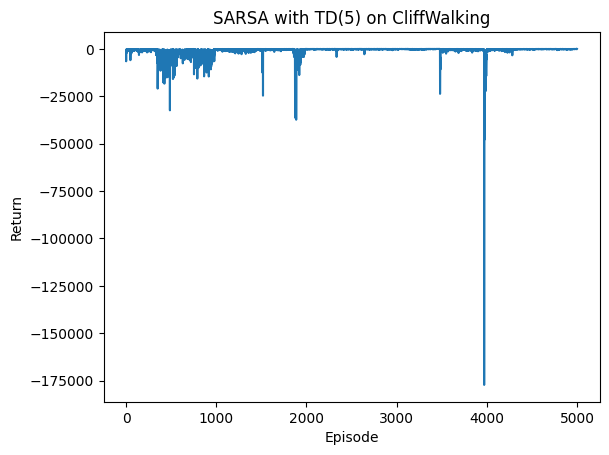

In [10]:
"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

def epsilon_greedy(Q, state, n_actions, epsilon):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

def SARSA_TD5():
  # Environment
  env = gym.make("CliffWalking-v1")

  # Parameters
  n_states = env.observation_space.n
  n_actions = env.action_space.n
  alpha = 0.1           # step size (learning rate)
  gamma = 0.99          # discount factor
  epsilon = 0.1         # epsilon for epsilon-greedy policy
  n_step = 5            # number of steps for TD(n)
  n_episodes = 5000

  # Initialize Q-table
  Q = np.zeros((n_states, n_actions))

  # Track returns
  episode_returns = []

  for ep in range(n_episodes):
      state, _ = env.reset()
      action = epsilon_greedy(Q, state, n_actions, epsilon)

      # Buffers to store the trajectory
      states = deque()
      actions = deque()
      rewards = deque()

      T = float("inf")
      t = 0
      G = 0
      done = False

      while True:
          if t < T:
              # Take real step in the environment
              next_state, reward, terminated, truncated, _ = env.step(action)
              done = terminated or truncated

              states.append(state)
              actions.append(action)
              rewards.append(reward)

              if done:
                  T = t + 1
              else:
                  next_action = epsilon_greedy(Q, next_state, n_actions, epsilon)
                  state = next_state
                  action = next_action

          # Time index for state/action to update
          tau = t - n_step + 1
          if tau >= 0:
              # TODO: Compute the n-step return G for state tau
              # Hint: use rewards[tau : tau+n] plus Q(s_t+n, a_t+n) if not terminal

              # Example structure:
              G = 0.0
              # accumulate discounted rewards
              for i in range(tau, min(tau + n_step, T)):
                  G += (gamma ** (i - tau)) * rewards[i]
              if tau + n_step < T and (tau + n_step) < len(states):
                  s_tau_n = states[tau + n_step]
                  a_tau_n = actions[tau + n_step]
                  G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

              # TODO: Update Q[states[tau], actions[tau]] toward G
              Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

          if tau == T - 1:
              break

          t += 1

      episode_returns.append(sum(rewards))
  return episode_returns, Q, n_actions

returns, Q, n_actions = SARSA_TD5()

# Plot learning curve
plt.plot(returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking")
plt.show()


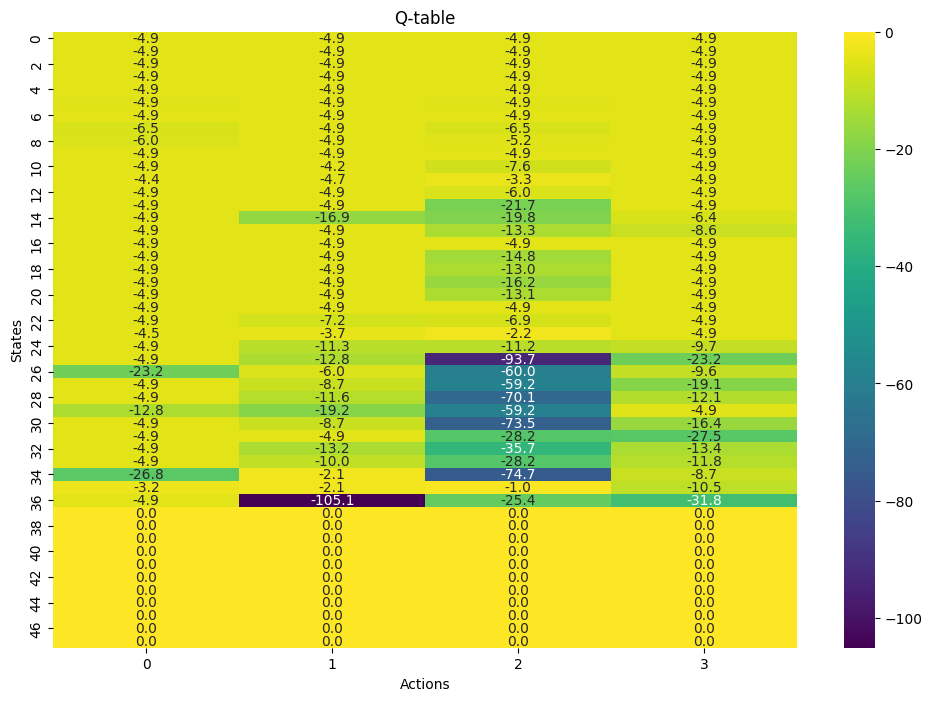

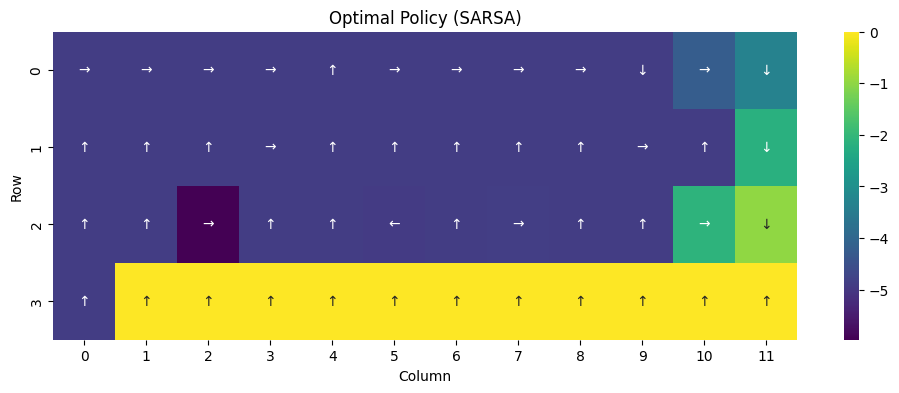

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_Q(Q):
  plt.figure(figsize=(12, 8))
  sns.heatmap(Q, annot=True, fmt=".1f", cmap="viridis")
  plt.xlabel("Actions")
  plt.ylabel("States")
  plt.title("Q-table")
  plt.show()

plot_Q(Q)

def plot_policy(Q, title="SARSA"):
  # Reshape Q table to a 4x12 grid
  Q_grid = Q.reshape((4, 12, n_actions))

  # Get the optimal action for each state and its corresponding Q-value
  optimal_action = np.argmax(Q_grid, axis=2)
  optimal_policy_Q = np.max(Q_grid, axis=2)


  # Define arrow mapping based on action space (0: up, 1: right, 2: down, 3: left)
  action_arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
  optimal_policy_arrows = np.vectorize(action_arrows.get)(optimal_action)


  plt.figure(figsize=(12, 4))
  sns.heatmap(optimal_policy_Q, annot=optimal_policy_arrows, fmt="", cmap="viridis", cbar=True) # Add color bar back
  plt.xlabel("Column")
  plt.ylabel("Row")
  plt.title("Optimal Policy (SARSA)")
  plt.show()
plot_policy(Q)

As seen in the plot, n-step SARSA generally converges faster than 1-step SARSA, since it propagates information about delayed rewards more quickly. However, the 5-step version exhibits more variance during learning, making updates noisier. Thus, the trade-off is between safer but slower learning (1-step) and faster but riskier learning (n-step).

## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




Episode 1: total reward = -94
Episode 2: total reward = -496
Episode 3: total reward = -496
Episode 4: total reward = -298
Episode 5: total reward = -199
Episode 6: total reward = -298
Episode 7: total reward = -298
Episode 8: total reward = -199
Episode 9: total reward = -100
Episode 10: total reward = -199
Episode 11: total reward = -100
Episode 12: total reward = -199
Episode 13: total reward = -100
Episode 14: total reward = -100
Episode 15: total reward = -96
Episode 16: total reward = -100
Episode 17: total reward = -85
Episode 18: total reward = -100
Episode 19: total reward = -100
Episode 20: total reward = -71
Episode 21: total reward = -100
Episode 22: total reward = -298
Episode 23: total reward = -45
Episode 24: total reward = -100
Episode 25: total reward = -199
Episode 26: total reward = -154
Episode 27: total reward = -100
Episode 28: total reward = -199
Episode 29: total reward = -49
Episode 30: total reward = -199
Episode 31: total reward = -199
Episode 32: total rewar

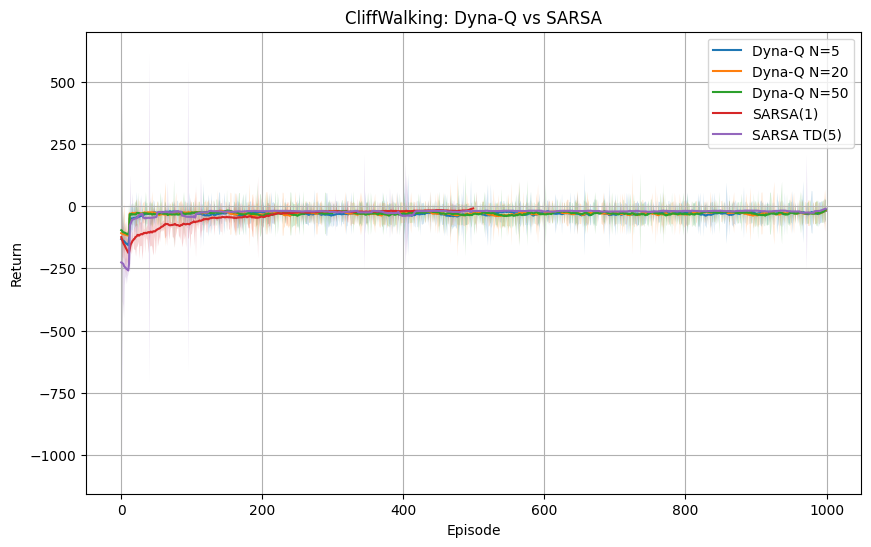

Sample efficiency (episodes to reach avg return ≥ -30):
Dyna-Q N=5: 10
Dyna-Q N=20: 2
Dyna-Q N=50: 12
SARSA(1): 188
SARSA TD(5): 41


In [22]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict, deque


# SARSA(n) with TD learning with parameters for steps
def sarsa_td(env, n_step=1, episodes=500, alpha=0.1, gamma=0.99, eps=0.05):
    n_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(n_actions))
    returns = np.zeros(episodes)

    for ep in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, n_actions, eps)

        states, actions, rewards = [state], [action], [0]
        T = float("inf")
        t = 0

        while True:
            if t < T:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                rewards.append(reward)
                states.append(next_state)
                if done:
                    T = t + 1
                else:
                    next_action = epsilon_greedy(Q, next_state, n_actions, eps)
                    actions.append(next_action)

            tau = t - n_step + 1
            if tau >= 0:
                G = 0.0
                for i in range(tau + 1, min(tau + n_step, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                if tau + n_step < T:
                    s_tau_n = states[tau + n_step]
                    a_tau_n = actions[tau + n_step]
                    G += (gamma ** n_step) * Q[s_tau_n][a_tau_n]
                s_tau, a_tau = states[tau], actions[tau]
                Q[s_tau][a_tau] += alpha * (G - Q[s_tau][a_tau])

            if tau == T - 1:
                break
            t += 1
            if t < T:
                action = actions[t]

        returns[ep] = sum(rewards[1:])  # drop dummy 0
    return returns

# reusing the old sarsa algorithm from lab 3
def sarsa_algo(env):
  n_episodes = 500      # number of episodes to run
  max_steps = 100     # safety cap

  # Q-learning parameters
  learning_rate = 0.1
  discount_factor = 0.99
  n_actions = env.action_space.n
  n_states = env.observation_space.n
  Q = np.zeros((n_states, n_actions))
  max_steps = 100     # safety cap

  total_reward_sarsa = []

  for episode in range(n_episodes):
      state, info = env.reset()
      done = False
      total_reward = 0
      action = epsilon_greedy(Q, state, n_actions, 0.05)

      for step in range(max_steps):
          # Random policy: sample an action uniformly
          #action = env.action_space.sample()
          next_state, reward, terminated, truncated, info = env.step(action)

          next_action = epsilon_greedy(Q, next_state, n_actions, 0.05)

          Q[state, action] = Q[state, action] + learning_rate * (reward + (discount_factor * Q[next_state, next_action]) - Q[state, action])

          total_reward += reward
          state = next_state
          action = next_action

          if terminated or truncated:
              break
      total_reward_sarsa.append(total_reward)
      print(f"Episode {episode+1}: total reward = {total_reward}")
  return total_reward_sarsa

# dyna-Q implementation
def dyna_q(env, planning_steps=5, episodes=500, alpha=0.1, gamma=0.99, eps=0.05):
    n_actions = env.action_space.n
    Q = defaultdict(lambda: np.zeros(n_actions))
    Model = {}
    returns = np.zeros(episodes)

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = epsilon_greedy(Q, state, n_actions, eps)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            # real Q-learning update
            Q[state][action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

            # update model
            Model[(state, action)] = (reward, next_state)

            # planning
            for _ in range(planning_steps):
                s_p, a_p = random.choice(list(Model.keys()))
                r_p, s_p_next = Model[(s_p, a_p)]
                Q[s_p][a_p] += alpha * (r_p + gamma * np.max(Q[s_p_next]) - Q[s_p][a_p])

            state = next_state

        returns[ep] = total_reward
    return returns

# function to simulate the experiment
def run_experiment(episodes=500, runs=5, seeds=None):
    # ensuring that each algorithm uses the same environment for consistency
    env = gym.make("CliffWalking-v1")
    results = {}
    seeds = seeds or [i for i in range(runs)]

    # dyna-Q with N = {5, 20, 50}
    for N in [5, 20, 50]:
        all_runs = []
        for seed in seeds:
            np.random.seed(seed); random.seed(seed)
            ret = dyna_q(env, planning_steps=N, episodes=episodes)
            all_runs.append(ret)
        results[f"Dyna-Q N={N}"] = np.vstack(all_runs)

    # SARSA(1)
    all_runs = []
    for seed in seeds:
        np.random.seed(seed); random.seed(seed)
        ret = sarsa_algo(env)
        all_runs.append(ret)
    results["SARSA(1)"] = np.vstack(all_runs)

    # SARSA TD(5)
    all_runs = []
    for seed in seeds:
        np.random.seed(seed); random.seed(seed)
        ret = sarsa_td(env, n_step=5, episodes=episodes)
        all_runs.append(ret)
    results["SARSA TD(5)"] = np.vstack(all_runs)

    env.close()
    return results

# plotting
def plot_results(results, window=20):
    plt.figure(figsize=(10,6))
    for label, data in results.items():
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        smoothed = np.convolve(mean, np.ones(window)/window, mode="same")
        plt.plot(smoothed, label=label)
        plt.fill_between(range(len(mean)), smoothed-std, smoothed+std, alpha=0.2)
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("CliffWalking: Dyna-Q vs SARSA")
    plt.legend()
    plt.grid(True)
    plt.show()

# sample efficiency metric
def compute_sample_efficiency(results, threshold=-30, window=100):
    eff = {}
    for label, data in results.items():
        mean = np.mean(data, axis=0)
        rolling = np.convolve(mean, np.ones(window)/window, mode="valid")
        idx = np.argmax(rolling > threshold)
        eff[label] = idx if rolling[idx] > threshold else None
    return eff

# Run experiment
results = run_experiment(episodes=1000, runs=5, seeds=[0,1,2,3,4])  # using different seeds to ensure randomness
plot_results(results)

efficiency = compute_sample_efficiency(results, threshold=-30)
print("Sample efficiency (episodes to reach avg return ≥ -30):")
for k,v in efficiency.items():
    print(f"{k}: {v}")


## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
